In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Apr  2 12:04:37 2023

@author: pelletier
"""

import numpy as np
import matplotlib.pyplot as plt
import Recipes
from Constants import Rsun, Rjup, au
from astropy.table import Table

transit_dates = ["2020sep03", "2020sep12", "2021nov28"]

instr_resolution = 85000


# define velocity grids for cross-correlation
RVs = np.arange(-400, 401, 1)
Kp_range = np.arange(-300, 301, 1)
Vsys_range = np.arange(-100, 101, 1)

# define which species to cross-correlate
species = ["Fe"]
# species = ['Fe','Na','Ca+','Cr','Li','H','V','VO','Mn','Ni','Mg','Ca','K',
#             'Ba+','O','Fe+']

# load atmospheric model templates for each species
model_wave = np.load("models/wave.npy")
model_flux = np.zeros([len(species), len(model_wave)])
for i, specie in enumerate(species):
    model_flux[i, :] = np.load("models/{}.npy".format(specie))

# load each time series (3 transits, each with 2 spectral channels)
nights = []
for date in transit_dates:
    for arm in ["blue", "red"]:
        print("=====================================")
        print("{} ({})".format(date, arm))
        print("=====================================")
        night = Recipes.LoadNight(night_directory="../data/" + date + "/", arm=arm)
        night.date = date
        night.arm = arm
        night.Vsys_range = Vsys_range
        night.Kp_range = Kp_range
        # reference values from the literature
        night.Kp_0 = 196.52  # Ehrenreich+2020 (km/s)
        night.Vsys_0 = -1.16  # Ehrenreich+2020 (km/s)
        night.kRV = 116  # Ehrenreich+2020 (m/s)
        night.tt = 2448.89524293553 + 2457000  # TESS
        night.per = 1.8098956637628 * 24 * 3600  # TESS
        night.Rstar = 1.756 * Rsun  # Ehrenreich+2020
        night.Rp = 1.854 * Rjup  # Ehrenreich+2020
        night.b = 0.027  # Ehrenreich+2020
        night.ap = 0.033 * au  # Ehrenreich+2020
        # get rid of nans in data
        night.discard_bad_data()
        # calculate the phase position and expected RV shift of WASP-76b for every exposure
        night.calc_planet_net_RV_shift()
        # calculate transit  ingress/egress information and out-of-transit exposures
        night.calc_transit_properties()
        # correct for 5 sigma outliers
        counts_start_corrected = night.correct_bad_pixels(
            flux=night.counts_start * 1, sigma=5
        )
        # counts_start_corrected = night.correct_bad_pixels(flux=night.counts_start*1, sigma = 30)
        # build telluric mask to be applied later, mask out regions between 760 and 770nm
        night.build_regions_mask([[0.76, 0.77]])
        # night.build_regions_mask([[0.1, 0.11]])
        # move to the stellar rest frame (correct for WASP-76 and Earth's motion (but not WASP-76b the planet))
        counts_start_corrected = night.shift_to_frame(
            counts_start_corrected, night.BERV - night.star_vels
        )
        # calculate uncertainty per pixel as prescribed in Gibson et al 2020 (bottom right of page 3)
        noise_model = night.get_noise_model(counts_start_corrected * 1)
        # align spectra to common continuum - à la Gibson et al. 2022 (box width - 501, Gaussian width = 100)
        preped_flux = night.spec_alignment(
            flux=counts_start_corrected * 1,
            spectrum_alignment="hpf",
            box_width=21,
            gaussian_width=50,
            keep_steps=True,
        )
        # preped_flux = night.spec_alignment(flux=counts_start_corrected*1, spectrum_alignment='hpf', box_width=501, gaussian_width=100, keep_steps=True)
        # clean data (fit out-of-transit spectrum and apply PCA, remove 10 components in this case)
        night.flux = night.process_data(
            preped_flux * 1.0,
            Npcs_removed=10,
            keep_steps=True,
            sigmas=noise_model,
            Print=True,
        )
        # update orders in case
        night.update_orders(night.flux)
        # rebuilt transmission model (what has been removed from the data - this is in what we will inject models in for retrievals)
        RebuiltTransmission = preped_flux / night.flux
        # uncertainty at every pixel
        sigmas = noise_model / RebuiltTransmission
        # cross-correlation
        model_wave, prepd_model_flux = night.Prep_model_for_CCF(
            model_wave, model_flux, resolution=instr_resolution
        )
        # model_wave, prepd_model_flux = Funcs.BroadenSpec(wave=model_wave, flux=model_flux, end_resolution=night.instr_resolution, Print=True)
        # Cross-correlate data with model(s) for each order, exposure, and RV shift
        CCF_mat = night.CCF(
            fluxes=night.flux,
            pla_mod_wave=model_wave,
            pla_mod_flux=prepd_model_flux,
            sigmas=sigmas,
            Planet_RVs=RVs,
        )
        # build a mask to block out a region in RV space of width = 10 km/s centered on Vsys (to mask out RM effect)
        night.calc_CCF_mask(RM_mask=10, RM_center=0)
        # phase-fold CCF matrix to compute SNR maps, weigh exposures by transit model
        night.calc_SNRmap(
            CCF_mat=CCF_mat, exposure_weights=night.exposure_weights, box_half_width=40
        )

        night.reduction_steps.append(sigmas)
        night.CCF_mat = CCF_mat
        # night.save(filename=date+arm)
        nights.append(night)

2020sep03 (blue)
Loading Exposures
Bringing all specs to the same wavelength grid
Number of exposures = 43, average exposure time = 340.0s, average overhead = 79.0s
Night integration duration = 5.0 hours
Calculating RV assuming circular orbit (from phase)
Phase change from 0.959 to 0.071 during night
Velocity change from -50.1km/s to 85.26km/s (27.71km/s per hour)
Fitting out median spectrum from each exposure


/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:255: RuntimeWarning: invalid value encountered in sqrt
  mu_e = np.sqrt(1 - x_e**2 - b**2)
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:256: RuntimeWarning: invalid value encountered in sqrt
  mu_w = np.sqrt(1 - x_w**2 - b**2)
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:272: RuntimeWarning: invalid value encountered in sqrt
  mu_smooth = np.sqrt(1 - x_smooth**2 - b**2)
/Users/Victini/miniforge3/envs/poseidon_eq/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Total number of big segments = 0
Total number of outliers = 1377
Fitting noise model


/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:2441: RuntimeWarning: overflow encountered in scalar power
  return np.sqrt(a * F + 10**b)
/Users/Victini/miniforge3/envs/poseidon_eq/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:2441: RuntimeWarning: overflow encountered in scalar power
  return np.sqrt(a * F + 10**b)
/Users/Victini/miniforge3/envs/poseidon_eq/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:2441: RuntimeWarning: overflow encountered in scalar power
  return np.sqrt(a * F + 10**b)
/Users/Victini/miniforge3/envs/poseidon_eq/lib/python3.9/

Bringing all specs to a common continuum


/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:711: RuntimeWarning: All-NaN slice encountered
  med_spec = np.nanmedian(flux, axis=0)
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:2962: RuntimeWarning: All-NaN slice encountered
  out = func(data_ext[index], axis=1)


Double High Pass took 0.126 minutes
Fitting out median spectrum from each exposure
Applying PCA: removing 10 components


/Users/Victini/miniforge3/envs/poseidon_eq/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Masking >4 sigma standard deviation columns (672 columns total (0.5% of the data)).
Preparing 1 models for cross-correlation
Starting Cross-Correlation
Cross-Correlation: took 0.336 minutes
Applying mask 10km/s mask centered at 0km/s
2020sep03 (red)
Loading Exposures
Bringing all specs to the same wavelength grid
Number of exposures = 43, average exposure time = 300.0s, average overhead = 119.0s
Night integration duration = 5.0 hours
Calculating RV assuming circular orbit (from phase)
Phase change from 0.959 to 0.071 during night
Velocity change from -50.22km/s to 85.12km/s (27.71km/s per hour)
Fitting out median spectrum from each exposure


/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:255: RuntimeWarning: invalid value encountered in sqrt
  mu_e = np.sqrt(1 - x_e**2 - b**2)
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:256: RuntimeWarning: invalid value encountered in sqrt
  mu_w = np.sqrt(1 - x_w**2 - b**2)
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:272: RuntimeWarning: invalid value encountered in sqrt
  mu_smooth = np.sqrt(1 - x_smooth**2 - b**2)
/Users/Victini/miniforge3/envs/poseidon_eq/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Total number of big segments = 7
Total number of outliers = 507
Fitting noise model
Bringing all specs to a common continuum


/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:711: RuntimeWarning: All-NaN slice encountered
  med_spec = np.nanmedian(flux, axis=0)
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:2962: RuntimeWarning: All-NaN slice encountered
  out = func(data_ext[index], axis=1)


Double High Pass took 0.104 minutes
Fitting out median spectrum from each exposure
Applying PCA: removing 10 components


/Users/Victini/miniforge3/envs/poseidon_eq/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Masking >4 sigma standard deviation columns (305 columns total (0.3% of the data)).
Preparing 1 models for cross-correlation
Starting Cross-Correlation
Cross-Correlation: took 0.268 minutes
Applying mask 10km/s mask centered at 0km/s
2020sep12 (blue)
Loading Exposures
Bringing all specs to the same wavelength grid
Number of exposures = 47, average exposure time = 340.0s, average overhead = 67.0s
Night integration duration = 5.3 hours
Calculating RV assuming circular orbit (from phase)
Phase change from 0.935 to 0.055 during night
Velocity change from -78.17km/s to 66.29km/s (27.74km/s per hour)
Fitting out median spectrum from each exposure


/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:255: RuntimeWarning: invalid value encountered in sqrt
  mu_e = np.sqrt(1 - x_e**2 - b**2)
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:256: RuntimeWarning: invalid value encountered in sqrt
  mu_w = np.sqrt(1 - x_w**2 - b**2)
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:272: RuntimeWarning: invalid value encountered in sqrt
  mu_smooth = np.sqrt(1 - x_smooth**2 - b**2)
/Users/Victini/miniforge3/envs/poseidon_eq/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Total number of big segments = 0
Total number of outliers = 179
Fitting noise model
Bringing all specs to a common continuum


/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:711: RuntimeWarning: All-NaN slice encountered
  med_spec = np.nanmedian(flux, axis=0)
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:2962: RuntimeWarning: All-NaN slice encountered
  out = func(data_ext[index], axis=1)


Double High Pass took 0.136 minutes
Fitting out median spectrum from each exposure
Applying PCA: removing 10 components


/Users/Victini/miniforge3/envs/poseidon_eq/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Masking >4 sigma standard deviation columns (732 columns total (0.5% of the data)).
Preparing 1 models for cross-correlation
Starting Cross-Correlation
Cross-Correlation: took 0.445 minutes
Applying mask 10km/s mask centered at 0km/s
2020sep12 (red)
Loading Exposures
Bringing all specs to the same wavelength grid
Number of exposures = 47, average exposure time = 300.0s, average overhead = 108.0s
Night integration duration = 5.3 hours
Calculating RV assuming circular orbit (from phase)
Phase change from 0.935 to 0.055 during night
Velocity change from -78.32km/s to 66.14km/s (27.74km/s per hour)
Fitting out median spectrum from each exposure


/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:255: RuntimeWarning: invalid value encountered in sqrt
  mu_e = np.sqrt(1 - x_e**2 - b**2)
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:256: RuntimeWarning: invalid value encountered in sqrt
  mu_w = np.sqrt(1 - x_w**2 - b**2)
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:272: RuntimeWarning: invalid value encountered in sqrt
  mu_smooth = np.sqrt(1 - x_smooth**2 - b**2)
/Users/Victini/miniforge3/envs/poseidon_eq/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Total number of big segments = 0
Total number of outliers = 698
Fitting noise model
Bringing all specs to a common continuum


/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:711: RuntimeWarning: All-NaN slice encountered
  med_spec = np.nanmedian(flux, axis=0)
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:2962: RuntimeWarning: All-NaN slice encountered
  out = func(data_ext[index], axis=1)


Double High Pass took 0.117 minutes
Fitting out median spectrum from each exposure
Applying PCA: removing 10 components


/Users/Victini/miniforge3/envs/poseidon_eq/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Masking >4 sigma standard deviation columns (372 columns total (0.3% of the data)).
Preparing 1 models for cross-correlation
Starting Cross-Correlation
Cross-Correlation: took 0.339 minutes
Applying mask 10km/s mask centered at 0km/s
2021nov28 (blue)
Loading Exposures
Bringing all specs to the same wavelength grid
Number of exposures = 36, average exposure time = 480.0s, average overhead = 104.0s
Night integration duration = 5.8 hours
Calculating RV assuming circular orbit (from phase)
Phase change from 0.931 to 0.062 during night
Velocity change from -82.62km/s to 74.2km/s (27.63km/s per hour)
Fitting out median spectrum from each exposure


/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:255: RuntimeWarning: invalid value encountered in sqrt
  mu_e = np.sqrt(1 - x_e**2 - b**2)
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:256: RuntimeWarning: invalid value encountered in sqrt
  mu_w = np.sqrt(1 - x_w**2 - b**2)
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:272: RuntimeWarning: invalid value encountered in sqrt
  mu_smooth = np.sqrt(1 - x_smooth**2 - b**2)
/Users/Victini/miniforge3/envs/poseidon_eq/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Total number of big segments = 0
Total number of outliers = 2871
Fitting noise model


/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:2441: RuntimeWarning: overflow encountered in scalar power
  return np.sqrt(a * F + 10**b)
/Users/Victini/miniforge3/envs/poseidon_eq/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:2441: RuntimeWarning: overflow encountered in scalar power
  return np.sqrt(a * F + 10**b)
/Users/Victini/miniforge3/envs/poseidon_eq/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:2441: RuntimeWarning: overflow encountered in scalar power
  return np.sqrt(a * F + 10**b)
/Users/Victini/miniforge3/envs/poseidon_eq/lib/python3.9/

Bringing all specs to a common continuum


/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:711: RuntimeWarning: All-NaN slice encountered
  med_spec = np.nanmedian(flux, axis=0)


Double High Pass took 0.107 minutes
Fitting out median spectrum from each exposure
Applying PCA: removing 10 components


/Users/Victini/miniforge3/envs/poseidon_eq/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Masking >4 sigma standard deviation columns (608 columns total (0.5% of the data)).
Preparing 1 models for cross-correlation
Starting Cross-Correlation
Cross-Correlation: took 0.283 minutes
Applying mask 10km/s mask centered at 0km/s
2021nov28 (red)
Loading Exposures
Bringing all specs to the same wavelength grid
Number of exposures = 36, average exposure time = 480.0s, average overhead = 104.0s
Night integration duration = 5.8 hours
Calculating RV assuming circular orbit (from phase)
Phase change from 0.931 to 0.062 during night
Velocity change from -82.62km/s to 74.2km/s (27.63km/s per hour)
Fitting out median spectrum from each exposure


/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:255: RuntimeWarning: invalid value encountered in sqrt
  mu_e = np.sqrt(1 - x_e**2 - b**2)
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:256: RuntimeWarning: invalid value encountered in sqrt
  mu_w = np.sqrt(1 - x_w**2 - b**2)
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:272: RuntimeWarning: invalid value encountered in sqrt
  mu_smooth = np.sqrt(1 - x_smooth**2 - b**2)


Total number of big segments = 79
Total number of outliers = 2994
Fitting noise model
Bringing all specs to a common continuum


/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:711: RuntimeWarning: All-NaN slice encountered
  med_spec = np.nanmedian(flux, axis=0)


Double High Pass took 0.09 minutes
Fitting out median spectrum from each exposure
Applying PCA: removing 10 components


/Users/Victini/miniforge3/envs/poseidon_eq/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Masking >4 sigma standard deviation columns (399 columns total (0.4% of the data)).
Preparing 1 models for cross-correlation
Starting Cross-Correlation
Cross-Correlation: took 0.247 minutes
Applying mask 10km/s mask centered at 0km/s


/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:255: RuntimeWarning: invalid value encountered in sqrt
  mu_e = np.sqrt(1 - x_e**2 - b**2)
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:256: RuntimeWarning: invalid value encountered in sqrt
  mu_w = np.sqrt(1 - x_w**2 - b**2)
/Users/Victini/Desktop/POSEIDON/high_res_experiments/data/WASP-76b-MAROON/OneDrive_1_8-30-2023/Recipes.py:272: RuntimeWarning: invalid value encountered in sqrt
  mu_smooth = np.sqrt(1 - x_smooth**2 - b**2)


Applying mask 10km/s mask centered at 0km/s


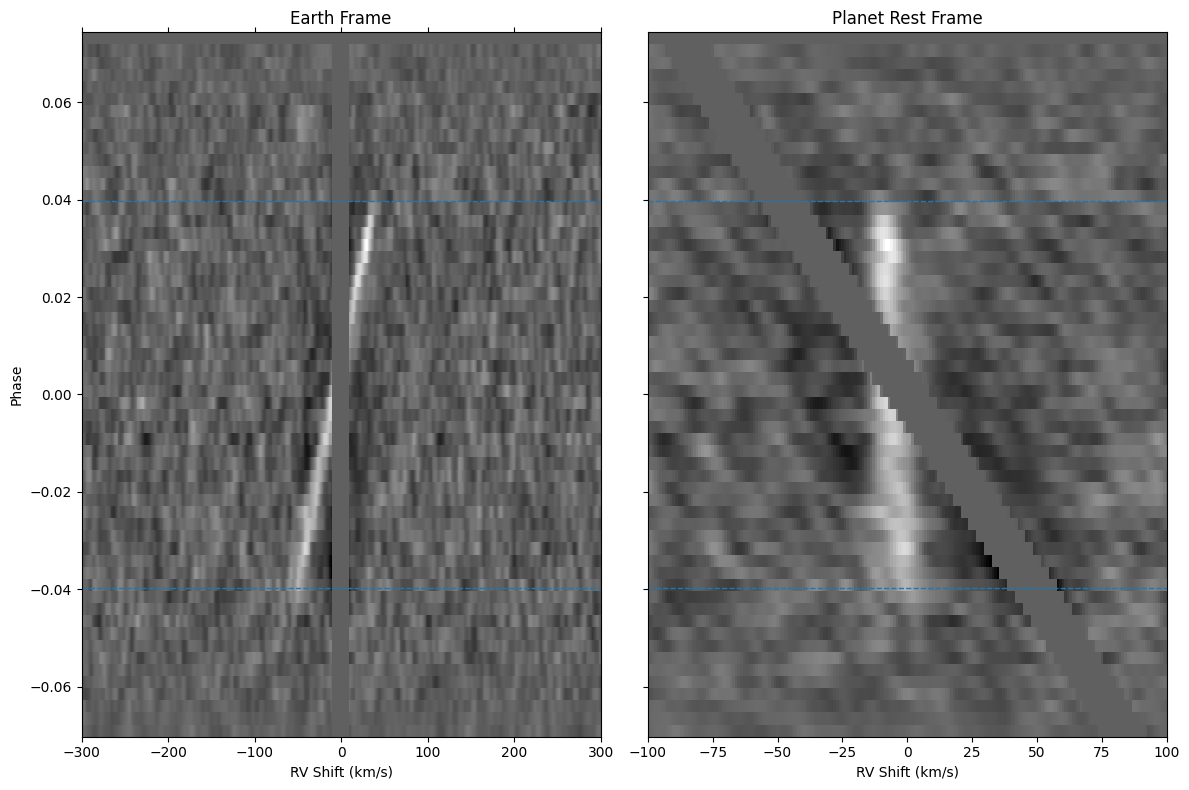

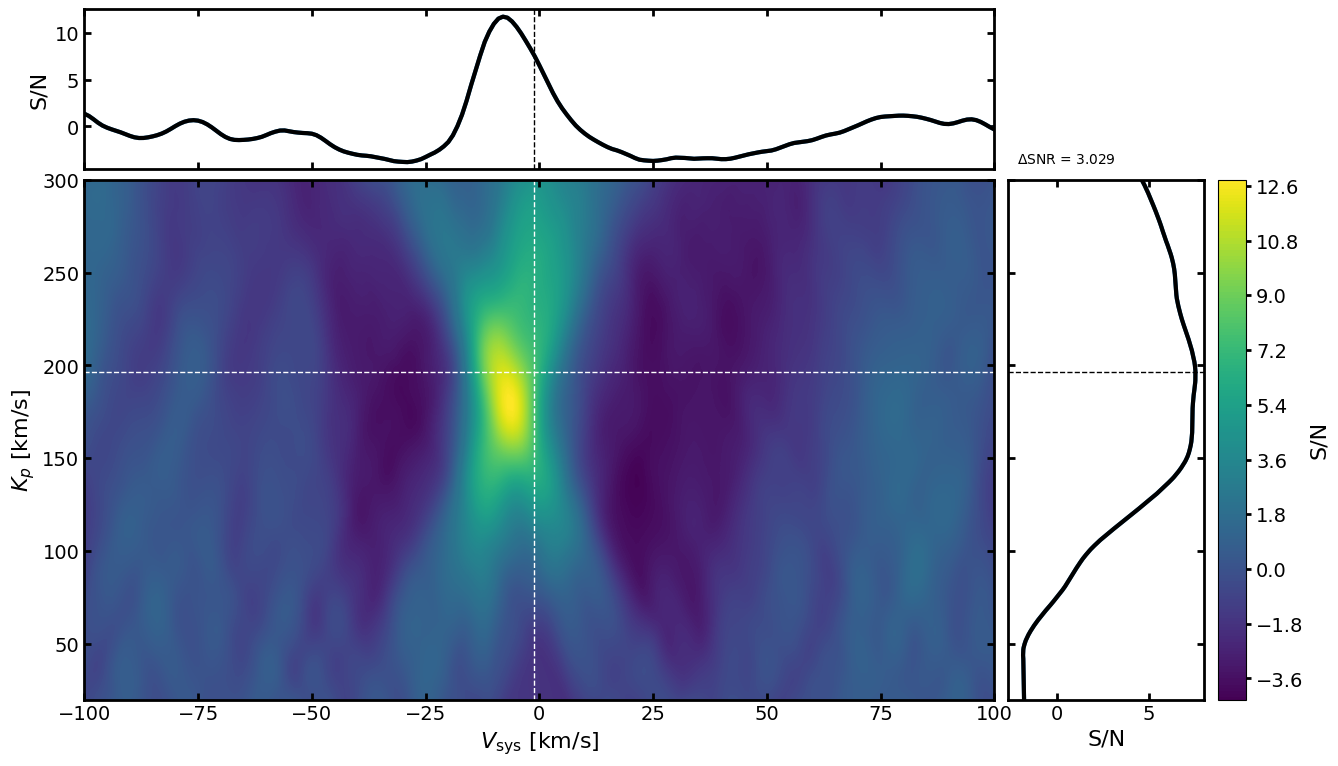

In [2]:
phase_grid = Recipes.gen_common_phase_grid(nights)
# interpolate each night on this phase grid
ni = Recipes.combine_nights(nights, phase_grid)
plotting = True
if plotting:
    if len(np.shape(model_flux)) == 1:
        ni.plotCCOrbit2(
            ni.SummedCCF_mat[0],
            xlim=[-300, 300],
            apply_CCF_mask=True,
            savepath="Trail_" + specie,
        )
        ni.plotKpVsys(ni.SNRmapCCF[0], ylim=[20, None], savepath="Map_" + specie)
    else:
        for j, specie in enumerate(species):
            ni.plotCCOrbit2(
                ni.SummedCCF_mat[j],
                xlim=[-300, 300],
                apply_CCF_mask=True,
                savepath="Trail_" + specie,
            )
            ni.plotKpVsys(ni.SNRmapCCF[j], ylim=[20, None], savepath="Map_" + specie)